# Advanced line detection

## Import packages

In [57]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

%load_ext autoreload
%autoreload 2

from calibration import *
from pipeline import *
from helpers import *
from line import *

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Camera Calibration

### Helper functions

Helpers function are defined in helpers.py file

### Load and display images for calibration:

In [ ]:
calibration_image_list = {}

for i,fileName in enumerate(os.listdir("camera_cal/")):
    image = mpimg.imread('camera_cal/' + fileName)
    calibration_image_list[fileName] = image
    
plot_images_map(calibration_image_list)

### Calibrate the camera

Show calibrated images, real calibration is in calibration.py

In [ ]:
undistored_images = {}

# undistort calibration images
for file_name in images_with_corners:
    image = mpimg.imread(file_name)        
    undistored_images[file_name] = cv2.undistort(image, mtx, dist, None, mtx) 

print("found ", len(images_with_corners), "image(s) with corners in ", len(calibration_image_list), "images and undistored ", len(undistored_images))    

### Show images with cornes

In [ ]:
plot_images_map(images_with_corners)

### Show undistored images 

In [ ]:
plot_images_map(undistored_images)

## Example of calibration

In [ ]:
# plot big images of "original" and "undistorted" for "camera_cal/calibration4.jpg"
image = mpimg.imread("camera_cal/calibration1.jpg")
undistorted = cv2.undistort(image, mtx, dist, None, mtx)
plot_images_map({"original" : image, "undistorted" : undistorted}, columns=2, img_size=(40, 110))


# Process test images

## Load and display images

In [ ]:
test_images = {}
undistorted_test_images = {}

for i,fileName in enumerate(os.listdir("test_images/")):
    image = mpimg.imread('test_images/' + fileName)
    test_images[fileName] = image
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    test_images[fileName + "-undistorted"] = undistorted_image
    undistorted_test_images[fileName] = undistorted_image
    
plot_images_map(test_images, columns=2, img_size=(40, 110))

### HLS thresholding

In [ ]:
channels = {}
for file_name in undistorted_test_images :
    img = undistorted_test_images[file_name]
    channels[file_name + "original"] = img
    channels[file_name + "h"] = hls_select(img)
    channels[file_name + "l"] = hls_select(img, channel=1)
    channels[file_name + "s"] = hls_select(img, channel=2)

plot_images_map(channels, columns=4, img_size=(30, 50))

### Pipelines

#### videos

In [ ]:
challenge_video_output = 'results/challenge_video.mp4'
harder_challenge_video_output = 'results/harder_challenge_video.mp4'
project_video_output = 'results/project_video.mp4'

challenge_video = VideoFileClip("challenge_video.mp4")
harder_challenge_video = VideoFileClip("harder_challenge_video.mp4")
project_video = VideoFileClip("project_video.mp4")


#### Get frames from the videos for analysis

In [ ]:
for i in range(0,170):
    image = challenge_video.get_frame(i/2.0)
    cv2.imwrite('test_images_extra/challenge_video_{0}.jpg'.format(i), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

for i in range(0,170):
    image = harder_challenge_video.get_frame(i/2.0)
    cv2.imwrite('test_images_extra/harder_challenge_video_{0}.jpg'.format(i), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    
for i in range(0,170):
    image = project_video.get_frame(i/2.0)
    cv2.imwrite('test_images_extra/project_video_{0}.jpg'.format(i), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

#### test single image

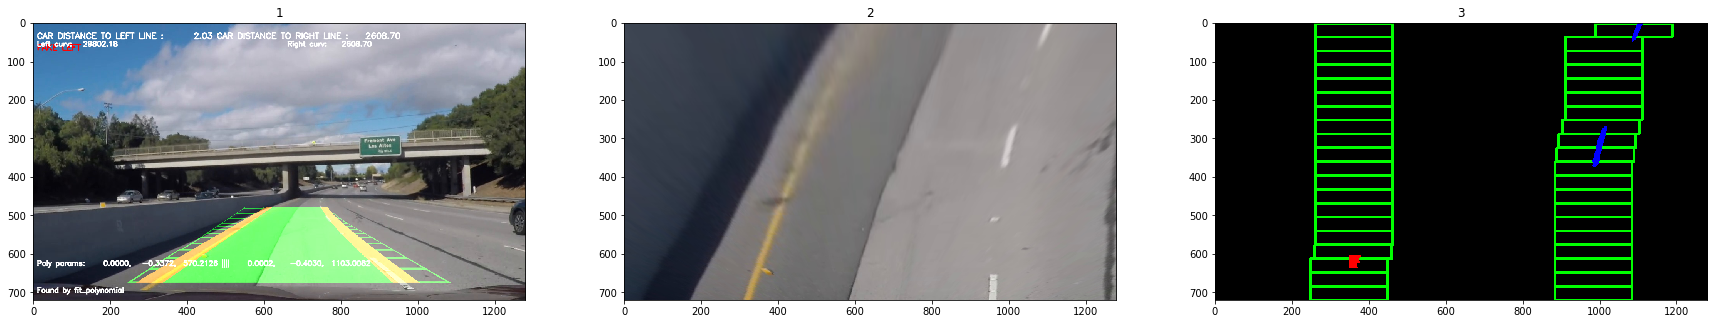

In [73]:
image = mpimg.imread('test_images_extra/challenge_video_5.jpg')
res = pipeline(image)
plot_images_map({"1":res[0], "2":res[1], "3":res[2] }, columns=3, img_size=(30, 50))

In [63]:
S = hls_select(res[2], 2)
def channel_threshold(channel, min=120, max=255):
    binary = np.zeros_like(channel)
    binary[(channel > 100) & (channel <= 255)] = 1
    
    return binary

binary = channel_threshold(S)


def erode_and_dilate(binary):
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.erode(binary,kernel,iterations = 2)

    kernel = np.ones((12,12),np.uint8)
    dilation = cv2.dilate(erosion,kernel,iterations = 3)
    return dilation

plot_images_map({"1":binary, "2":binary_output_sobel, "3": erode_and_dilate(binary_output_sobel)}, columns=3, img_size=(30, 50))

# # dilation[binary_output_sobel == 0] = 0

img1_bg = cv2.bitwise_and(res[2],res[2],mask = erode_and_dilate(binary_output_sobel))

plt.imshow(img1_bg)



error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'


In [68]:
def process_image(image):
    return pipeline(image)[0]

In [69]:
challenge_video_output = 'results/challenge_video.mp4'
harder_challenge_video_output = 'results/harder_challenge_video.mp4'
project_video_output = 'results/project_video.mp4'

challenge_video = VideoFileClip("challenge_video.mp4")
harder_challenge_video = VideoFileClip("harder_challenge_video.mp4")
project_video = VideoFileClip("project_video.mp4")

# Process videos

In [70]:
challenge_video_clip = challenge_video.fl_image(process_image) 
%time challenge_video_clip.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video results/challenge_video.mp4
[MoviePy] Writing video results/challenge_video.mp4


100%|██████████| 485/485 [01:04<00:00,  6.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/challenge_video.mp4 

CPU times: user 4min 23s, sys: 20.8 s, total: 4min 44s
Wall time: 1min 5s


In [8]:
harder_challenge_video_clip = harder_challenge_video.fl_image(process_image) 
%time harder_challenge_video_clip.write_videofile(harder_challenge_video_output, audio=False)

[MoviePy] >>>> Building video results/harder_challenge_video.mp4
[MoviePy] Writing video results/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [06:26<00:00,  3.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/harder_challenge_video.mp4 

CPU times: user 22min 22s, sys: 1min 31s, total: 23min 54s
Wall time: 6min 29s


In [6]:
project_video_clip = project_video.fl_image(process_image) 
%time project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video results/project_video.mp4
[MoviePy] Writing video results/project_video.mp4


100%|█████████▉| 1260/1261 [04:04<00:00,  5.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/project_video.mp4 

CPU times: user 15min 38s, sys: 1min 1s, total: 16min 40s
Wall time: 4min 6s


# Display videos

## Challenge video clip

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_clip))

## Harder challenge video clip

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video_clip))

## Project video clip

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_clip))